In [102]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [103]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [104]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])  # Convertir a datetime

In [105]:
df.drop(df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)].index,axis=0,inplace=True)

In [106]:
df

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136943,2023-12-10,23,65,0,65,1,65,4,5,6,0,1,1.0,0.0,0.0
172276,2024-01-24,26,118,40,158,1,158,4,3,9,1,0,1.0,0.0,0.0
160191,2023-12-19,19,45,0,45,1,45,2,9,11,0,1,0.0,1.0,0.0


In [107]:
df = df.groupby('Order_Date')['Total_Sales'].sum()
df = df.asfreq('D')

In [108]:
df['dayofmonth'] = df.index.day
df.groupby('dayofmonth')['Total_Sales'].mean().plot(kind='bar', figsize=(12,6))

plt.title('Promedio de ventas por día del mes')
plt.xlabel('Día del mes')
plt.ylabel('Ventas promedio')
plt.show()

KeyError: 'dayofmonth'

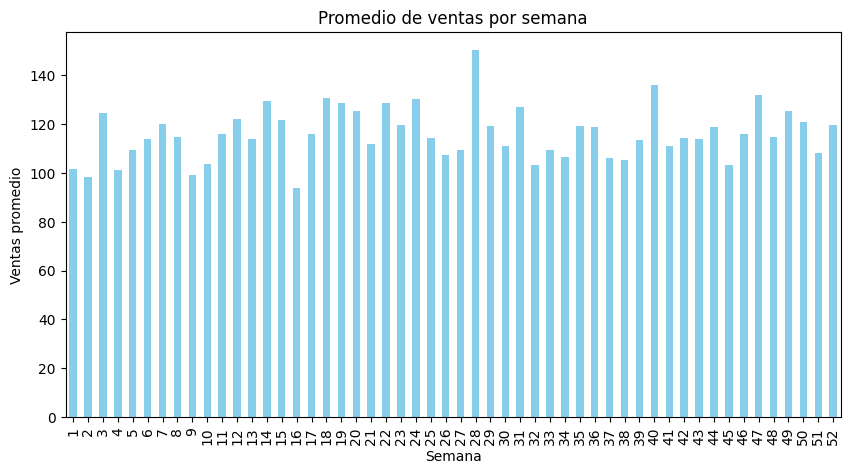

In [50]:
df['weekofyear'] = df.index.isocalendar().week
df.groupby('weekofyear')['Total_Sales'].mean().plot(kind='bar', figsize=(10,5), color='skyblue')

plt.title('Promedio de ventas por semana')
plt.xlabel('Semana')
plt.ylabel('Ventas promedio')
plt.show()

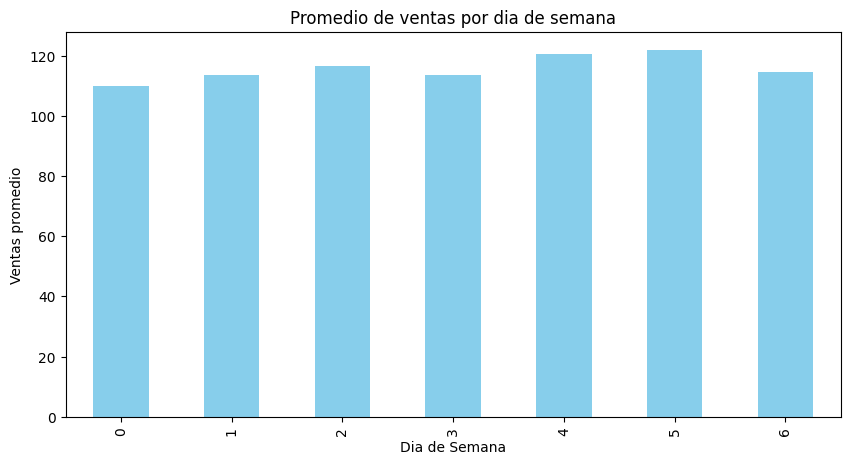

In [51]:
df['dayofweek'] = df.index.dayofweek
df.groupby('dayofweek')['Total_Sales'].mean().plot(kind='bar', figsize=(10,5), color='skyblue')

plt.title('Promedio de ventas por dia de semana')
plt.xlabel('Dia de Semana')
plt.ylabel('Ventas promedio')
plt.show()

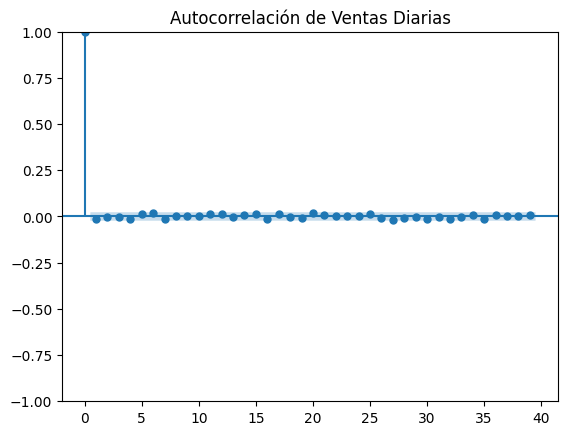

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt



# Graficar autocorrelación
plot_acf(df['Total_Sales'])  
plt.title("Autocorrelación de Ventas Diarias")
plt.show()


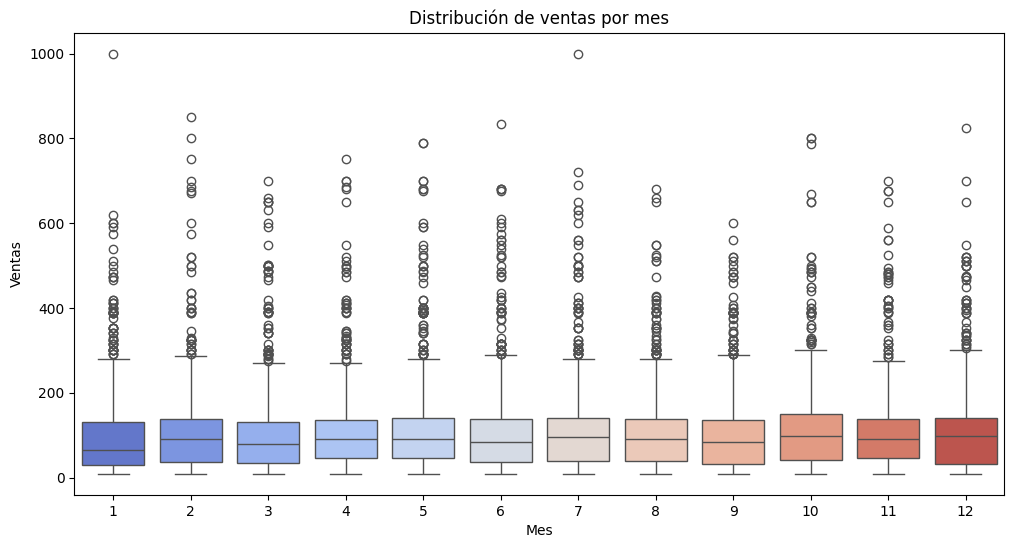

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df.index.month, y=df['Total_Sales'], palette="coolwarm")

plt.title('Distribución de ventas por mes')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.show()

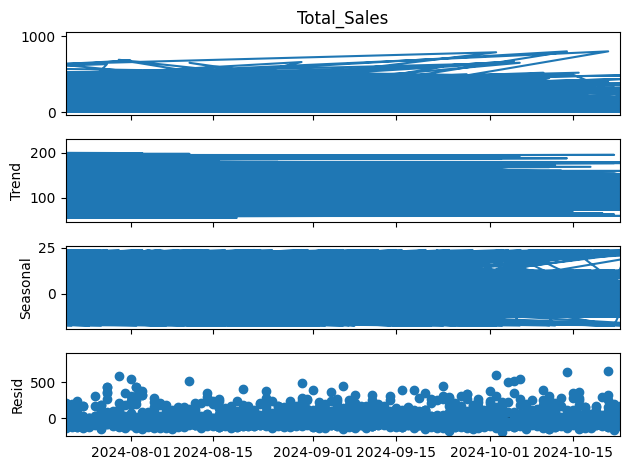

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Total_Sales'], model='additive', period=30)
result.plot()
plt.show()


In [19]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

df_daily = df.groupby(df['Order_Date'].dt.to_period('D'))['Total_Sales'].sum().reset_index()

df_daily['Order_Date'] = df_daily['Order_Date'].dt.to_timestamp()

df_daily.head()

,Order_Date,Total_Sales
0,2023-11-05,1954
1,2023-11-06,2007
2,2023-11-07,2652
3,2023-11-08,1651
4,2023-11-09,1982


In [20]:
df_daily = df_daily.rename(columns={'Order_Date': 'ds', 'Total_Sales': 'y'})

In [21]:
df_daily['ds'] = pd.to_datetime(df_daily['ds'])

In [22]:
df_daily['dayofweek'] = df_daily['ds'].dt.dayofweek
df_daily['quarter'] = df_daily['ds'].dt.quarter
df_daily['month'] = df_daily['ds'].dt.month
df_daily['year'] = df_daily['ds'].dt.year
df_daily['dayofyear'] = df_daily['ds'].dt.dayofyear
df_daily['dayofmonth'] = df_daily['ds'].dt.day
df_daily['weekofyear'] = df_daily['ds'].dt.isocalendar().week

In [23]:
train = df_daily.iloc[:290]
test = df_daily.iloc[290:]

In [24]:
model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=10,
    yearly_seasonality=True,
    weekly_seasonality=True
)
model.add_seasonality(name='weekly', period=7, fourier_order=3)

# Entrenar el modelo con los datos diarios
model.fit(train)


11:09:46 - cmdstanpy - INFO - Chain [1] start processing
11:09:47 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

In [26]:
forecast_test = forecast[['ds', 'yhat']].iloc[-len(test):]

In [27]:
# RMSE
rmse = root_mean_squared_error(test['y'], forecast_test['yhat'])

# MAE
mae = mean_absolute_error(test['y'], forecast_test['yhat'])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 775.19
MAE: 633.88


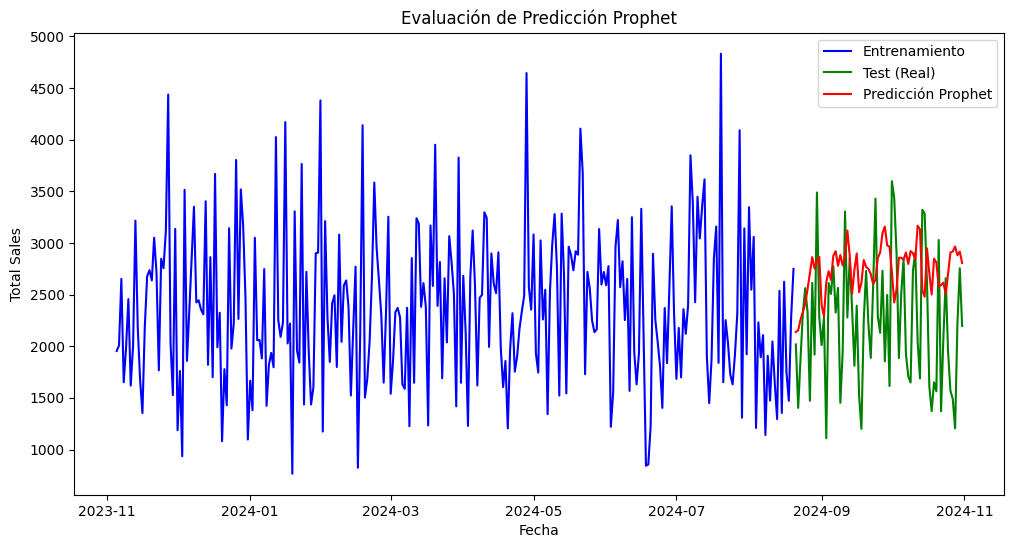

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label="Entrenamiento", color="blue")
plt.plot(test['ds'], test['y'], label="Test (Real)", color="green")
plt.plot(forecast_test['ds'], forecast_test['yhat'], label="Predicción Prophet", color="red")
plt.xlabel("Fecha")
plt.ylabel("Total Sales")
plt.title("Evaluación de Predicción Prophet")
plt.legend()
plt.show()